# **Transformers for Sentiment Classification:**

Welcome folks!, in the current project I will show you in detail how to implement four types of well-known transformer models making use of the transformers HuggingFace library and Keras API.

The main task corresponds to a multi-class text classification on Movie Reviews Competition and the dataset contains 156.060 instances for training, whereas the testing set contains 66.292 from which we have to classify among 5 classes. The sentiment labels are:

0 → Negative
1 → Somewhat negative
2 → Neutral
3 → Somewhat positive
4 → Positive
At the end of the project we will summarize and compare their performance according to our requirements and metrics.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-food-reviews-dataset/Amazon Food Reviews Dataset.csv


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter

import re
import gensim
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical


from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.initializers import Constant


import warnings
warnings.simplefilter('ignore')

In [3]:

#df=pd.read_csv("../input/amazon-reviews-on-sentiment-analysis/Amazon Reviews on Sentiment Analysis/train.csv")
#encoding='latin1', lineterminator='\n'
dframe = pd.read_csv("../input/amazon-food-reviews-dataset/Amazon Food Reviews Dataset.csv")
#df, validate, df_test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

Just to confirm the number of instances and features in each file:

In [4]:
dframe

,Id,Rating,Review
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...
...,...,...,...
568449,568450,5,Great for sesame chicken..this is a good if no...
568450,568451,2,I'm disappointed with the flavor. The chocolat...
568451,568452,5,"These stars are small, so you can give 10-15 o..."
568452,568453,5,These are the BEST treats for training and rew...


In [5]:
df_org = dframe.copy()
n=568454-60001
df_org=dframe.drop(dframe.tail(n).index,
        inplace = True)

In [6]:
dframe

,Id,Rating,Review
0,1,5,I have bought several of the Vitality canned d...
1,2,1,Product arrived labeled as Jumbo Salted Peanut...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
4,5,5,Great taffy at a great price. There was a wid...
...,...,...,...
59996,59997,1,Malted milk already has a fair amount of sugar...
59997,59998,5,My vegetable sour soup is very good because of...
59998,59999,5,"If you enjoy puffed whole grains, this is one ..."
59999,60000,5,I bought this item because the Arrowhead Mills...


In [7]:

df = dframe.sample(frac=0.8, random_state=25)
df_test = dframe.drop(df.index)

print(f"No. of training examples: {df.shape[0]}")
print(f"No. of testing examples: {df_test.shape[0]}")

No. of training examples: 48001
No. of testing examples: 12000


In [8]:
df.shape, df_test.shape

((48001, 3), (12000, 3))

In [9]:
df

,Id,Rating,Review
43419,43420,5,So glad they still have these in Germany!!! Wi...
49980,49981,5,"Try these you will love them not too sweet, bu..."
10655,10656,5,All I can say is that our two dogs love these ...
25654,25655,4,i have eaten these chips for years. they are n...
59440,59441,5,I love the gumbo. It is as close to the gumbo ...
...,...,...,...
38608,38609,5,"This is my favorite candy. DON""T CHEW IT! It i..."
57639,57640,5,Before eating these for the first time you mus...
53333,53334,5,"I've tried so many whole grain cereals, I can'..."
9184,9185,5,"Taste is a personal thing, isn't it. So I'll ..."


Above we can see that Review and Rating columns are all we need from the file in order to train the models later, therefore we will use these as feature (X) and label (Y) when fitting the transformer.

In [10]:
df_test

,Id,Rating,Review
20,21,5,My husband is a Twizzlers addict. We've bough...
22,23,5,I can remember buying this candy as a kid and ...
28,29,5,I got this for my Mum who is not diabetic but ...
32,33,4,McCann's Instant Oatmeal is great if you must ...
49,50,3,This is the same stuff you can buy at the big ...
...,...,...,...
59978,59979,5,These are just like the ones my grandmother bo...
59983,59984,5,I love these. That is the easiest way to put i...
59986,59987,5,This landjaeger is the REAL DEAL! I have actua...
59994,59995,5,Once again we find that you most often get wha...


In case there is a null or empty value in any column we should have to get rid of it, in order to find it out we will use info() as follows:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48001 entries, 43419 to 59347
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      48001 non-null  int64 
 1   Rating  48001 non-null  int64 
 2   Review  48001 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [12]:
df.isnull().sum()

Id        0
Rating    0
Review    0
dtype: int64

The dataset looks good and we need to know how are distributed the 5 classes in the label so as to know it's balanced or not.

In [13]:
df.Rating.value_counts()

5    30101
4     6839
1     4586
3     3791
2     2684
Name: Rating, dtype: int64

<AxesSubplot:title={'center':'Pie chart of Rating Class'}, ylabel='Rating'>

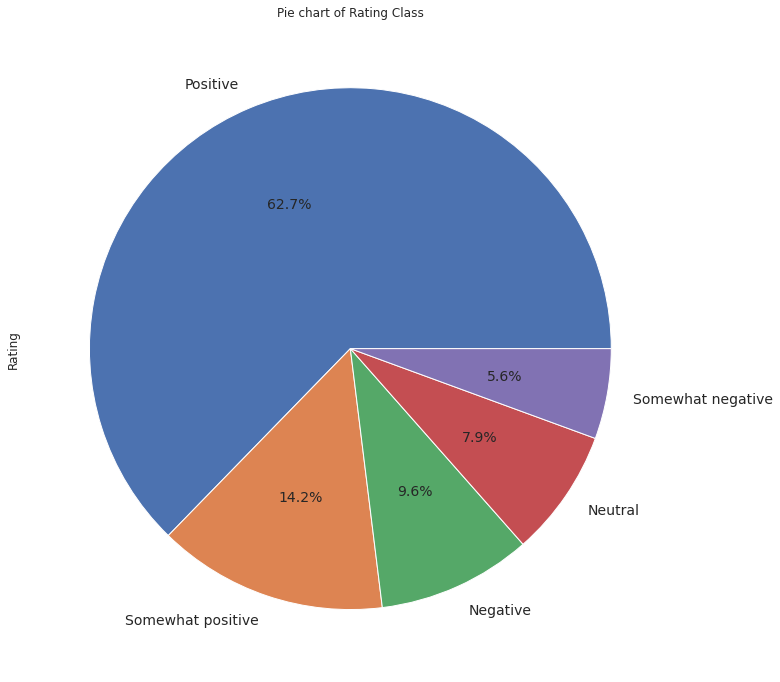

In [14]:
df2=df.copy(deep=True)
pie1=pd.DataFrame(df2['Rating'].replace(1,'Negative').replace(2,'Somewhat negative').replace(3,'Neutral').replace(4,'Somewhat positive').replace(5,'Positive').value_counts())
pie1.reset_index(inplace=True)
pie1.plot(kind='pie', title='Pie chart of Rating Class',y = 'Rating', 
          autopct='%1.1f%%', shadow=False, labels=pie1['index'], legend = False, fontsize=14, figsize=(12,12))

Time now to find out the number of words in reviews, in order to understand a bit better we will plot histograms for each class

Text(0.5, 0.98, 'Histogram number of words in reviews')

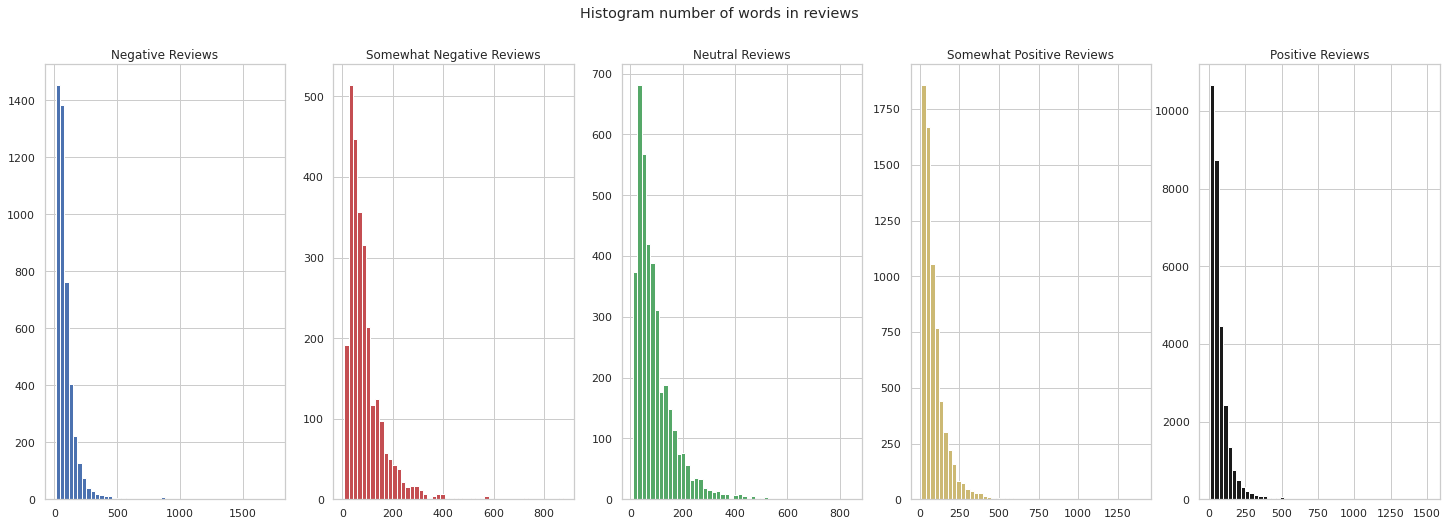

In [15]:
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(25,8))

ax1.hist(df[df['Rating'] == 1]['Review'].str.split().map(lambda x: len(x)), bins=50, color='b')
ax1.set_title('Negative Reviews')

ax2.hist(df[df['Rating'] == 2]['Review'].str.split().map(lambda x: len(x)), bins=50, color='r')
ax2.set_title('Somewhat Negative Reviews')

ax3.hist(df[df['Rating'] == 3]['Review'].str.split().map(lambda x: len(x)), bins=50, color='g')
ax3.set_title('Neutral Reviews')

ax4.hist(df[df['Rating'] == 4]['Review'].str.split().map(lambda x: len(x)), bins=50, color='y')
ax4.set_title('Somewhat Positive Reviews')

ax5.hist(df[df['Rating'] == 5]['Review'].str.split().map(lambda x: len(x)), bins=50, color='k')
ax5.set_title('Positive Reviews')

f.suptitle('Histogram number of words in reviews')

In the 5 histograms we can see the distribution behaves like a negative exponential function decreasing significatively as the x-axis increases. It seems like the longest sentence in Review column corresponds to a class 'Negative Reviews' and is around 52 words, now let's obtain the longest one by using the max() function:

In [16]:
df['Review'].str.split().map(lambda x: len(x)).max()

1751

In [17]:
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=20)
print('Number of sentences which contain more than 20 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=30)
print('Number of sentences which contain more than 30 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=40)
print('Number of sentences which contain more than 40 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))>=50)
print('Number of sentences which contain more than 50 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')
dfff=pd.DataFrame(df['Review'].str.split().map(lambda x: len(x))==52)
print('Number of sentences which contain 52 words: ', dfff.loc[dfff['Review']==True].shape[0])
print(' ')

Number of sentences which contain more than 20 words:  46638
 
Number of sentences which contain more than 30 words:  38737
 
Number of sentences which contain more than 40 words:  32353
 
Number of sentences which contain more than 50 words:  27088
 
Number of sentences which contain 52 words:  470
 


Modeling
In this step we will build, train and compare the following algorithms:

BERT (Bidirectional Encoder Representation from Transformers)

XLNet (Generalized Auto-Regressive model)

RoBERTa (Robustly Optimized BERT Pre-training Approach)

DistilBERT (Distilled BERT)

Each one of the mentioned have its pros and cons, the most preferred and widely used model is the BERT for being the middle term in performance, whereas RoBERTa and .. are known for their better error metrics and DistilBERT for its faster training. We will consider all of these chracteristics and choose the best one for our dataset.

Firstly, we have to install the transformers library offered by HuggingFace so as enable all useful functions when building the four models.

In [18]:
!pip install transformers

Then what we need from tensorflow.keras:

In [19]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

Now we have to gather from the dataset only the two columns useful for training (Review and Rating):

In [20]:
data = df[['Review', 'Rating']]

# Set your model output as categorical and save in new label col
data['Rating_label'] = pd.Categorical(data['Rating'])

# Transform your output to numeric
data['Rating'] = data['Rating_label'].cat.codes

In [21]:
data_train, data_val = train_test_split(data, test_size = 0.1)

# **BERT:**



As first step we have to import the Model, Config and Tokenizer corresponding to Bert in order to build properly the model.

In [22]:
from transformers import TFBertModel,  BertConfig, BertTokenizerFast

2022-09-16 03:00:46.610018: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 03:00:46.614642: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 03:00:46.618738: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 03:00:46.626056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [23]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_bert_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [24]:
### ------- Build the model ------- ###
# with strategy.scope():
# Load the MainLayer
bert = transformer_bert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
bert (TFBertMainLayer)       TFBaseModelOutputWithPool 109482240 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 109,486,085
Trainable params: 109,486,085
Non-trainable params: 0
_________________________________________________________________


The next cell considers the tokenization of training and testing sentences, setting of label as categorical and finally model training.

In [25]:
### ------- Train the model ------- ###

# Set an optimizer
#5e-05
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)
#optimizer = Adam(learning_rate=3e-4,epsilon=10e-8,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Rating'])

x_val = tokenizer(
          text=data_val['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    
    batch_size=64,
    epochs=20,
    verbose=1)

2022-09-16 03:02:18.335285: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
675/675 [==============================] - 262s 360ms/step - loss: 0.8337 - accuracy: 0.6922
Epoch 2/20
675/675 [==============================] - 243s 360ms/step - loss: 0.6945 - accuracy: 0.7369
Epoch 3/20
675/675 [==============================] - 243s 360ms/step - loss: 0.6473 - accuracy: 0.7557
Epoch 4/20
675/675 [==============================] - 243s 360ms/step - loss: 0.6156 - accuracy: 0.7694
Epoch 5/20
675/675 [==============================] - 243s 360ms/step - loss: 0.5931 - accuracy: 0.7776
Epoch 6/20
675/675 [==============================] - 243s 360ms/step - loss: 0.5743 - accuracy: 0.7854
Epoch 7/20
675/675 [==============================] - 243s 360ms/step - loss: 0.5619 - accuracy: 0.7910
Epoch 8/20
675/675 [==============================] - 243s 360ms/step - loss: 0.5497 - accuracy: 0.7959
Epoch 9/20
675/675 [==============================] - 243s 360ms/step - loss: 0.5392 - accuracy: 0.7994
Epoch 10/20
675/675 [==============================] - 243s 360m

The model took 31 minutes and 16 seconds to train for 2 epochs.

# **Evaluate on Train+Test set(BERT):**

We will compute the error metrics on the validation set in order to have an idea of the model performance.

In [26]:
model_eval = model.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Rating': y_val}
)

151/151 [==============================] - 18s 97ms/step - loss: 0.8516 - accuracy: 0.7207


In [27]:
model_eval = model.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

1350/1350 [==============================] - 90s 65ms/step - loss: 0.3913 - accuracy: 0.8664


In [28]:
y_val_predicted = model.predict(
    x={'input_ids': x_val['input_ids']},
)

In [29]:
y_train_predicted = model.predict(
    x={'input_ids': x_train['input_ids']},
)

y_train_predicted corresponds to a numpy array representing the instances and the prediction as one-hot encoded, the actual label is formatted in the same manner, let's them see in detail:

In [30]:
y_val_predicted['Rating']

array([[-3.0149117, -3.0216553, -1.2923338,  2.0080035,  3.4666717],
       [-2.9207084, -3.0334713, -1.2505138,  2.5113204,  3.2036302],
       [-2.4189274, -2.938103 , -2.3267112,  0.9820025,  5.214844 ],
       ...,
       [-3.4520977, -2.8447926, -0.6035312,  3.1011927,  2.6058714],
       [ 2.7479272,  0.164342 , -0.6968725, -1.9093904, -0.9740942],
       [-2.9733942, -2.9105961, -1.0987825,  2.0737746,  3.8132787]],
      dtype=float32)

In [31]:
y_train_predicted['Rating']

array([[-3.82217   , -2.3937235 ,  0.36409134,  3.2291892 ,  1.3470403 ],
       [-2.9313686 , -3.0738661 , -2.16551   ,  1.7941396 ,  5.117948  ],
       [-2.1913335 , -1.7439607 ,  0.12772115,  1.410044  ,  0.83391446],
       ...,
       [ 4.2893806 ,  1.3806852 , -0.3409253 , -2.6876173 , -2.160323  ],
       [ 2.946997  ,  3.2391675 ,  1.0594757 , -1.8733002 , -3.897259  ],
       [ 1.4432454 ,  2.8286114 ,  2.221085  , -1.160798  , -4.28717   ]],
      dtype=float32)

In [32]:
y_val

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [33]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In order to compute the classification report and confusion matrix we will convert the matrices to one column representing the argmax for each row:

In [34]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Rating']]

In [35]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [36]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [37]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [38]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.65      0.61      0.63       482
           1       0.21      0.41      0.28       142
           2       0.36      0.38      0.37       354
           3       0.33      0.44      0.38       527
           4       0.91      0.83      0.87      3296

    accuracy                           0.72      4801
   macro avg       0.49      0.53      0.51      4801
weighted avg       0.76      0.72      0.74      4801



In [39]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.90      0.82      0.86      4545
           1       0.54      0.73      0.62      1802
           2       0.69      0.76      0.72      3086
           3       0.55      0.81      0.66      4175
           4       0.98      0.90      0.94     29592

    accuracy                           0.87     43200
   macro avg       0.73      0.80      0.76     43200
weighted avg       0.89      0.87      0.88     43200



The fact that our dataset is unbalanced in classes makes our prediction absolutely sidetracked towards the most frequent class, in this case (2: 'Neutral'), because of this the performance of the model is poor when predicting classes 0 or 4, making our model almost unuseful for this task. Below we can see for these 2 classes the number of misclassifications is huge.

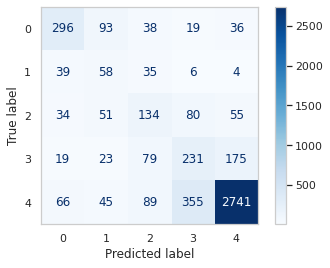

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

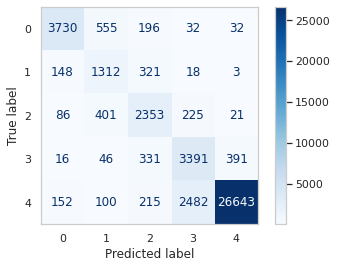

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(BERT):**

In this step we will predict the classes corresponding to the test set (out-of-bag) instances, because of the huge dataset we can expect to have almost same performance.

In [42]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [43]:
label_predicted = model.predict(
    x={'input_ids': x_test['input_ids']},
)

In [44]:
label_predicted['Rating']

array([[-1.6549091 , -2.0586112 , -1.3932093 ,  0.45725733,  2.5194466 ],
       [-2.7414258 , -3.0742514 , -2.1855116 ,  1.8479832 ,  4.7774024 ],
       [-2.7183378 , -3.056961  , -1.8666877 ,  1.8721522 ,  3.7500215 ],
       ...,
       [-1.8481367 , -3.1728928 , -2.4099896 ,  0.4252712 ,  4.856608  ],
       [-2.4658089 , -3.1420732 , -2.3824883 ,  1.2010014 ,  5.291272  ],
       [-1.2621412 , -2.2460449 , -1.6218994 ,  0.17691134,  2.4453013 ]],
      dtype=float32)

In [45]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [46]:
label_pred_max[:10]

[4, 4, 4, 3, 0, 0, 4, 0, 4, 4]

We will build the next 3 models the same way as the previous one, notice there are some lines which includes extra functions proper for the model:

In [47]:
#Cheers!!!

# **XLNet:**

The tokenizer corresponding to XLNet requires an extra library called sentencepiece which we have to install and import as follows:

In [48]:
!pip install sentencepiece 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
from transformers import XLNetTokenizer, TFXLNetModel, XLNetConfig
import sentencepiece

In [50]:
### --------- Setup XLNet ---------- ###

model_name = 'xlnet-base-cased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = XLNetConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load XLNet tokenizer
tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the XLNet model
transformer_xlnet_model = TFXLNetModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [51]:
from keras.layers import Input
import tensorflow as tf

In [52]:
### ------- Build the model ------- ###

# Load the MainLayer
xlnet = transformer_xlnet_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers XLNet model as a layer in a Keras model
xlnet_model = xlnet(inputs)[0]
xlnet_model = tf.squeeze(xlnet_model[:, -1:, :], axis=1)
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(xlnet_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model4 = Model(inputs=inputs, outputs=outputs, name='XLNet_MultiClass')

# Take a look at the model
model4.summary()

Model: "XLNet_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
transformer (TFXLNetMainLaye TFXLNetModelOutput(last_h 116718336 
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 1, 768)            0         
_________________________________________________________________
tf.compat.v1.squeeze (TFOpLa (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 116,722,181
Trainable params: 116,722,181
Non-trainable params: 0
____________________________________

In [53]:
### ------- Train the model ------- ###

# Set an optimizer

optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model4.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

y_val = to_categorical(data_val['Rating'])

x_val = tokenizer(
          text=data_val['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model4.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    
    batch_size=64,
    epochs=20,
    verbose=1)

Epoch 1/20
675/675 [==============================] - 310s 431ms/step - loss: 0.8041 - accuracy: 0.7029
Epoch 2/20
675/675 [==============================] - 291s 431ms/step - loss: 0.6805 - accuracy: 0.7436
Epoch 3/20
675/675 [==============================] - 291s 431ms/step - loss: 0.6405 - accuracy: 0.7592
Epoch 4/20
675/675 [==============================] - 291s 431ms/step - loss: 0.6121 - accuracy: 0.7687
Epoch 5/20
675/675 [==============================] - 291s 431ms/step - loss: 0.5915 - accuracy: 0.7756
Epoch 6/20
675/675 [==============================] - 291s 431ms/step - loss: 0.5752 - accuracy: 0.7808
Epoch 7/20
675/675 [==============================] - 291s 431ms/step - loss: 0.5621 - accuracy: 0.7865
Epoch 8/20
675/675 [==============================] - 291s 431ms/step - loss: 0.5510 - accuracy: 0.7916
Epoch 9/20
675/675 [==============================] - 291s 431ms/step - loss: 0.5435 - accuracy: 0.7943
Epoch 10/20
675/675 [==============================] - 291s 431m

The model took 31 minutes and 16 seconds to train for 2 epochs.

# **Evaluate on Train+Test set(XLNET):**

In [54]:
model_eval = model4.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Rating': y_val}
)

151/151 [==============================] - 17s 94ms/step - loss: 0.8188 - accuracy: 0.7332


In [55]:
model_eval = model4.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

1350/1350 [==============================] - 105s 76ms/step - loss: 0.3779 - accuracy: 0.8598


In [56]:
y_val_predicted = model4.predict(
    x={'input_ids': x_val['input_ids']},
)

In [57]:
y_train_predicted = model4.predict(
    x={'input_ids': x_train['input_ids']},
)

In [58]:
y_val_predicted['Rating']

array([[-3.4015293 , -2.2253418 , -0.0479161 ,  2.8820872 ,  3.933967  ],
       [-3.3571537 , -2.521671  , -0.07929933,  3.348552  ,  2.8419654 ],
       [-3.0525048 , -3.761815  , -2.5446749 ,  1.0515765 ,  6.241444  ],
       ...,
       [-4.3167677 , -3.683716  ,  0.03235721,  3.7160563 ,  3.766461  ],
       [ 1.4361668 ,  0.83098215,  0.14379412, -0.81166196, -2.2554002 ],
       [-2.0395944 , -1.4146264 ,  1.2934117 ,  2.71197   ,  0.2604918 ]],
      dtype=float32)

In [59]:
y_train_predicted['Rating']

array([[-4.3335285 , -2.3684287 ,  0.8454549 ,  4.432859  ,  2.5425065 ],
       [-3.76109   , -3.704049  , -1.5667303 ,  2.0154712 ,  5.8551016 ],
       [-3.1717756 , -3.54786   , -0.31211025,  3.770382  ,  3.4685106 ],
       ...,
       [ 5.440461  ,  0.94061023,  0.5529059 , -2.566824  , -2.0862947 ],
       [ 1.2150949 ,  3.1078713 ,  2.1521852 , -2.212014  , -5.891216  ],
       [ 0.57157284,  2.6763284 ,  3.4314368 , -1.7293537 , -5.4845543 ]],
      dtype=float32)

In [60]:
y_val

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [61]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [62]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Rating']]

In [63]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [64]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [65]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [66]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       471
           1       0.29      0.44      0.35       176
           2       0.36      0.41      0.38       329
           3       0.35      0.47      0.40       520
           4       0.92      0.84      0.88      3305

    accuracy                           0.73      4801
   macro avg       0.51      0.56      0.53      4801
weighted avg       0.77      0.73      0.75      4801



In [67]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      4394
           1       0.56      0.75      0.64      1796
           2       0.71      0.74      0.73      3287
           3       0.54      0.76      0.63      4368
           4       0.97      0.90      0.94     29355

    accuracy                           0.86     43200
   macro avg       0.73      0.80      0.76     43200
weighted avg       0.88      0.86      0.87     43200



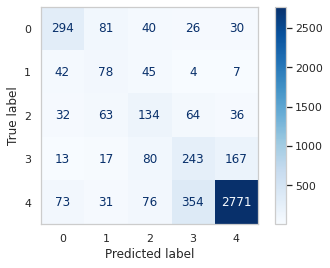

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

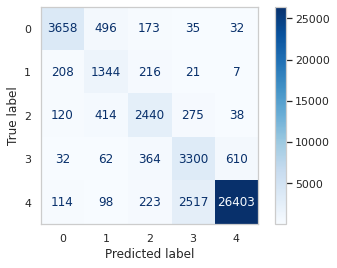

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(XLNET):**

In [70]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [71]:
label_predicted = model4.predict(
    x={'input_ids': x_test['input_ids']},
)

In [72]:
label_predicted['Rating']

array([[-2.3034747 , -2.7300506 , -2.5511947 ,  1.4150362 ,  4.360024  ],
       [-3.646741  , -4.00138   , -0.97823524,  2.960818  ,  6.2751327 ],
       [-4.430517  , -3.845445  , -1.802953  ,  2.936886  ,  5.918216  ],
       ...,
       [-2.9679923 , -3.3828864 , -2.198886  ,  1.6314925 ,  6.118519  ],
       [-3.6357563 , -3.6856802 , -1.9424694 ,  3.7338161 ,  4.538939  ],
       [-1.8921121 , -2.8066747 , -0.6198194 ,  1.2889779 ,  3.851355  ]],
      dtype=float32)

In [73]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [74]:
label_pred_max[:10]

[4, 4, 4, 3, 0, 0, 2, 0, 4, 4]

We will build the next 2 models the same way as the previous one, notice there are some lines which includes extra functions proper for the model:

In [75]:
#Cheers!!!

# **RoBERTa:**

In [76]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig  

In [77]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [78]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_MultiClass')

# Take a look at the model
model2.summary()

Model: "RoBERTa_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
roberta (TFRobertaMainLayer) TFBaseModelOutputWithPool 124645632 
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 124,649,477
Trainable params: 124,649,477
Non-trainable params: 0
_________________________________________________________________


In [79]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model2.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Rating'])

x_val = tokenizer(
          text=data_val['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model2.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
  
    batch_size=64,
    epochs=20,
    verbose=1)

Epoch 1/20
675/675 [==============================] - 266s 365ms/step - loss: 0.7960 - accuracy: 0.7055
Epoch 2/20
675/675 [==============================] - 246s 365ms/step - loss: 0.6749 - accuracy: 0.7449
Epoch 3/20
675/675 [==============================] - 246s 365ms/step - loss: 0.6355 - accuracy: 0.7613
Epoch 4/20
675/675 [==============================] - 246s 365ms/step - loss: 0.6123 - accuracy: 0.7691
Epoch 5/20
675/675 [==============================] - 246s 365ms/step - loss: 0.5953 - accuracy: 0.7744
Epoch 6/20
675/675 [==============================] - 246s 365ms/step - loss: 0.5823 - accuracy: 0.7806
Epoch 7/20
675/675 [==============================] - 246s 365ms/step - loss: 0.5707 - accuracy: 0.7861
Epoch 8/20
675/675 [==============================] - 246s 365ms/step - loss: 0.5622 - accuracy: 0.7879
Epoch 9/20
675/675 [==============================] - 246s 365ms/step - loss: 0.5520 - accuracy: 0.7923
Epoch 10/20
675/675 [==============================] - 246s 365m

The model took 26 minutes to train for 2 epochs.

# **Evaluate on validation set(RoBERTa):**

In [80]:
model_eval = model2.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Rating': y_val}
)

151/151 [==============================] - 18s 97ms/step - loss: 0.7859 - accuracy: 0.7280


In [81]:
model_eval = model2.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

1350/1350 [==============================] - 91s 66ms/step - loss: 0.4316 - accuracy: 0.8426


In [82]:
y_val_predicted = model2.predict(
    x={'input_ids': x_val['input_ids']},
)

In [83]:
y_train_predicted = model2.predict(
    x={'input_ids': x_train['input_ids']},
)

In [84]:
y_val_predicted['Rating']

array([[-3.1225696 , -3.180494  , -1.3159359 ,  2.1253722 ,  4.390498  ],
       [-3.7161696 , -3.159302  , -0.40295264,  3.4535692 ,  2.3397424 ],
       [-2.646828  , -2.7844217 , -2.1957314 ,  0.9356385 ,  5.5081296 ],
       ...,
       [-3.5292227 , -3.2973447 , -1.2206855 ,  2.6666205 ,  3.924917  ],
       [ 1.545246  ,  0.31853116, -0.20085339, -0.9109043 , -0.5284227 ],
       [-2.6026437 , -1.5065999 ,  1.122344  ,  2.3044226 ,  0.32690242]],
      dtype=float32)

In [85]:
y_train_predicted['Rating']

array([[-3.6225693 , -2.597451  ,  0.3497841 ,  3.8015945 ,  1.0612937 ],
       [-3.1946003 , -3.2515419 , -1.8145809 ,  2.0264995 ,  4.9099026 ],
       [-3.3967705 , -2.7039597 , -0.12149531,  3.7417145 ,  1.4379771 ],
       ...,
       [ 4.6573324 ,  0.5441659 , -0.44320086, -2.0331137 , -2.176432  ],
       [ 0.7214404 ,  2.843326  ,  2.11035   , -0.9800101 , -3.563497  ],
       [ 0.33383724,  2.9668791 ,  2.528492  , -1.0618122 , -3.4345353 ]],
      dtype=float32)

In [86]:
y_val

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [87]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [88]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Rating']]

In [89]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [90]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [91]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [92]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.69      0.65      0.67       480
           1       0.27      0.43      0.33       168
           2       0.36      0.41      0.38       325
           3       0.33      0.44      0.38       514
           4       0.91      0.83      0.87      3314

    accuracy                           0.73      4801
   macro avg       0.51      0.55      0.52      4801
weighted avg       0.77      0.73      0.74      4801



In [93]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4575
           1       0.50      0.67      0.58      1818
           2       0.59      0.73      0.65      2787
           3       0.51      0.72      0.60      4387
           4       0.97      0.89      0.93     29633

    accuracy                           0.84     43200
   macro avg       0.69      0.76      0.72     43200
weighted avg       0.87      0.84      0.85     43200



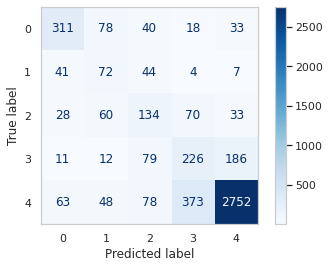

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

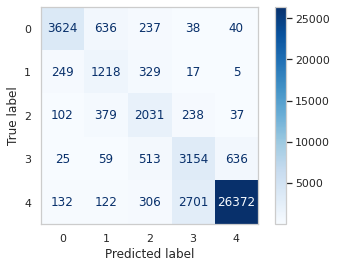

In [95]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(RoBERTa):**

In [96]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [97]:
label_predicted = model2.predict(
    x={'input_ids': x_test['input_ids']},
)

In [98]:
label_predicted['Rating']

array([[-1.2921673 , -1.2486931 , -1.1012697 ,  0.6311215 ,  2.5396054 ],
       [-2.6147223 , -2.8253577 , -2.2005808 ,  1.0700455 ,  5.433917  ],
       [-3.1108506 , -2.9564202 , -1.850816  ,  1.8406038 ,  4.54182   ],
       ...,
       [-2.215322  , -2.6567585 , -1.9752312 ,  0.48961765,  5.2545285 ],
       [-3.2598193 , -3.064899  , -1.9147372 ,  1.798164  ,  5.0939226 ],
       [-2.060187  , -1.9548483 , -0.9358107 ,  1.275888  ,  3.1003854 ]],
      dtype=float32)

In [99]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [100]:
label_pred_max[:10]

[4, 4, 4, 2, 0, 0, 3, 0, 4, 3]

In [101]:
#Cheers!!!

# **DistilBERT:**

In [102]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertConfig 

In [103]:
### --------- Setup DistilBERT ---------- ###

model_name = 'distilbert-base-uncased'

# Max length of tokens
max_length = 50

# Load transformers config and set output_hidden_states to False
config = DistilBertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Distilbert tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Distilbert model
transformer_distilbert_model = TFDistilBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-09-16 07:43:28.167092: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the 

In [104]:
### ------- Build the model ------- ###

# Load the MainLayer
distilbert = transformer_distilbert_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers DistilBERT model as a layer in a Keras model
distilbert_model = distilbert(inputs)[0][:,0,:]
dropout = Dropout(0.1, name='pooled_output')
pooled_output = dropout(distilbert_model, training=False)

# Then build your model output
Ratings = Dense(units=len(data_train.Rating_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='Rating')(pooled_output)
outputs = {'Rating': Ratings}

# And combine it all in a model object
model3 = Model(inputs=inputs, outputs=outputs, name='DistilBERT_MultiClass')

# Take a look at the model
model3.summary()

Model: "DistilBERT_MultiClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
distilbert (TFDistilBertMain TFBaseModelOutput(last_hi 66362880  
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 768)               0         
_________________________________________________________________
pooled_output (Dropout)      (None, 768)               0         
_________________________________________________________________
Rating (Dense)               (None, 5)                 3845      
Total params: 66,366,725
Trainable params: 66,366,725
Non-trainable params: 0
_________________________________________________________________


In [105]:
### ------- Train the model ------- ###

# Set an optimizer
optimizer = Adam(learning_rate=5e-05,epsilon=1e-08,decay=0.01,clipnorm=1.0)

# Set loss and metrics
loss = {'Rating': CategoricalCrossentropy(from_logits = True)}

# Compile the model
model3.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

# Ready output data for the model
y_train = to_categorical(data_train['Rating'])

# Tokenize the input (takes some time)
x_train = tokenizer(
          text=data_train['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

y_val = to_categorical(data_val['Rating'])

x_val = tokenizer(
          text=data_val['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = True,
          verbose = True)

# Fit the model
history = model3.fit(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train},
    batch_size=64,
    epochs=20,
    verbose=1)

Epoch 1/20
675/675 [==============================] - 134s 185ms/step - loss: 0.8483 - accuracy: 0.6874
Epoch 2/20
675/675 [==============================] - 125s 185ms/step - loss: 0.7293 - accuracy: 0.7262
Epoch 3/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6885 - accuracy: 0.7405
Epoch 4/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6650 - accuracy: 0.7510
Epoch 5/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6473 - accuracy: 0.7545
Epoch 6/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6346 - accuracy: 0.7609
Epoch 7/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6222 - accuracy: 0.7673
Epoch 8/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6143 - accuracy: 0.7695
Epoch 9/20
675/675 [==============================] - 125s 185ms/step - loss: 0.6080 - accuracy: 0.7738
Epoch 10/20
675/675 [==============================] - 125s 185m

The model took 14 minutes to train for 2 epochs.

# **Evaluate on Train+Test set(DistilBERT):**

In [106]:
model_eval = model3.evaluate(
    x={'input_ids': x_val['input_ids']},
    y={'Rating': y_val}
)

151/151 [==============================] - 9s 48ms/step - loss: 0.8111 - accuracy: 0.7188


In [107]:
model_eval = model3.evaluate(
    x={'input_ids': x_train['input_ids']},
    y={'Rating': y_train}
)

1350/1350 [==============================] - 47s 34ms/step - loss: 0.4964 - accuracy: 0.8198


In [108]:
y_val_predicted = model3.predict(
    x={'input_ids': x_val['input_ids']},
)

In [109]:
y_train_predicted = model3.predict(
    x={'input_ids': x_train['input_ids']},
)

In [110]:
y_val_predicted['Rating']

array([[-1.5701154 , -2.1354897 , -1.8521898 ,  0.63236874,  4.545735  ],
       [-2.3943925 , -1.6045312 , -0.00743228,  1.9274693 ,  2.0678203 ],
       [-2.485156  , -2.07728   , -1.9323349 ,  0.7586376 ,  4.5724134 ],
       ...,
       [-3.1906946 , -2.8781478 , -0.33832198,  3.0013132 ,  2.8541949 ],
       [ 3.248281  ,  1.0600001 , -0.17988147, -1.8951205 , -2.4396784 ],
       [-2.7824497 , -2.8622804 , -0.00557784,  2.673324  ,  2.7615895 ]],
      dtype=float32)

In [111]:
y_train_predicted['Rating']

array([[-3.3132906 , -2.1961253 ,  0.8422805 ,  2.505914  ,  1.6231502 ],
       [-2.684167  , -3.0943882 , -1.9286479 ,  2.033575  ,  4.865099  ],
       [-2.590929  , -1.1990556 ,  0.80252373,  2.5452504 ,  1.0114416 ],
       ...,
       [ 3.942129  ,  0.66133356, -0.83396816, -2.1189146 , -2.6026328 ],
       [ 2.4979677 ,  2.4422748 ,  0.46524128, -1.7185448 , -3.8751101 ],
       [ 1.1398559 ,  2.7493916 ,  1.6083691 , -1.7542725 , -4.029626  ]],
      dtype=float32)

In [112]:
y_val

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [113]:
y_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [114]:
y_val_pred_max=[np.argmax(i) for i in y_val_predicted['Rating']]

In [115]:
y_train_pred_max=[np.argmax(i) for i in y_train_predicted['Rating']]

In [116]:
y_val_actual_max=[np.argmax(i) for i in y_val]

In [117]:
y_train_actual_max=[np.argmax(i) for i in y_train]

In [118]:
from sklearn.metrics import classification_report

report = classification_report(y_val_pred_max, y_val_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       472
           1       0.26      0.39      0.31       175
           2       0.35      0.39      0.37       339
           3       0.29      0.45      0.35       437
           4       0.92      0.82      0.86      3378

    accuracy                           0.72      4801
   macro avg       0.49      0.53      0.50      4801
weighted avg       0.77      0.72      0.74      4801



In [119]:
from sklearn.metrics import classification_report

report = classification_report(y_train_pred_max, y_train_actual_max)

print(report)

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      4461
           1       0.45      0.60      0.51      1788
           2       0.58      0.67      0.62      2960
           3       0.43      0.69      0.53      3810
           4       0.97      0.87      0.92     30181

    accuracy                           0.82     43200
   macro avg       0.65      0.72      0.68     43200
weighted avg       0.86      0.82      0.83     43200



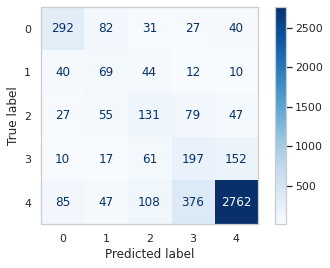

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_val_pred_max, y_val_actual_max), display_labels=np.unique(y_val_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

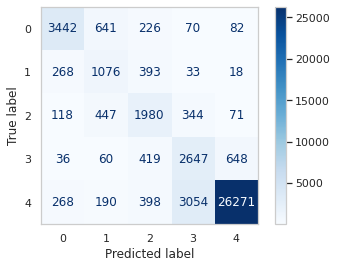

In [121]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train_pred_max, y_train_actual_max), display_labels=np.unique(y_train_actual_max))
disp.plot(cmap='Blues') 
plt.grid(False)

# **Inference(DistilBERT):**

In [122]:
x_test = tokenizer(
          text=df_test['Review'].to_list(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding=True, 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

In [123]:
label_predicted = model3.predict(
    x={'input_ids': x_test['input_ids']},
)

In [124]:
label_predicted['Rating']

array([[-0.95590997, -1.9886764 , -1.6709247 ,  0.3437832 ,  3.1173792 ],
       [-2.8057435 , -2.701277  , -1.5807638 ,  2.4576454 ,  4.30843   ],
       [-1.8495088 , -1.8736368 , -1.0129986 ,  1.9798378 ,  3.0502398 ],
       ...,
       [-1.8473091 , -2.3094602 , -2.0433624 ,  0.08586342,  4.736414  ],
       [-2.153803  , -2.872216  , -2.1887858 ,  1.4503506 ,  4.834258  ],
       [-0.49774435,  0.6505421 ,  0.9352852 ,  0.09551222, -0.9449605 ]],
      dtype=float32)

In [125]:
label_pred_max=[np.argmax(i) for i in label_predicted['Rating']]

In [126]:
label_pred_max[:10]

[4, 4, 4, 4, 0, 0, 2, 0, 4, 4]

In [127]:
#Cheers!!!

# **Discussion:**

In general the performance of the four models was similar, supporting the idea that BERT is the middle term of trade-off between accuracy and training time, whereas DistilBERT was the fastest by far, but having a lower accuracy than the previous as is explained by HuggingFace it achieves 95% accuracy of BERT, finally RoBERTa and XLNet were the models with highest accuracy and at the same time the slowest.

I have submitted the predition of the testing set for all models and the best one was RoBERTa reaching 68.62% of accuracy and the lowest was DistilBERT reaching 67.90%. We can say there is a slight difference but in terms of number of misclassifications the gap is huge, however the big challenge of the current task is how to deal with an unbalanced dataset, this is the main and perhaps the unique reason why we have such a poor performance even in the best one, despite the fact that increasing the max_length of sequences can increase a little bit the accuracy too, but not significatively. The method I would apply to solve this problem is undersampling in which we reduce the number of instances to the less frequent class which corresponds to 7.072 (Negative) as such number of instances is not too small and having 5 classes the dataset should finally have 35.360 sentences to compute, but obviously we are getting rid randomly of a big portion of the data.

Another possible solution could be to get rid of those reviews which are "vague" such as those with only one or two words classified as neutral, those really does not add too much to the training, but in contrast are others which have just a couple of words and are useful. This process would take a long time to do because it have to be done one by one, but it surely solves the problem.

Also I have to inform that I have trained for more than 2 epochs each model but the accuracy didn't increase or even decreased after the 3rd or 4th epoch, this is why in order to avoid more complex functions or early stopping I set to 2 epochs.

I would like to know any feedback in order to increase the performance of the models or tell me if you found a different one even better!

If you liked this notebook I would appreciate so much your upvote if you want to see more projects/tutorials like this one. I encourage you to see my projects portfolio, am sure you will love it.

Thank you!